In [29]:
from trnasimtools.serialize import SerializeTwoCodonSingleTranscript
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
date="june-5-2022"

In [3]:
#!mkdir ../yaml/june-5-2022
#!mkdir ../output/june-5-2022

In [58]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_len = 100
transcript_copy_number = 100
ribosome_copy_number = 100
total_trna = 100
ribosome_binding_rate = 1.0
trna_charging_rates = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0, 2.5, 5.0, 7.5, 10.0]

In [8]:
# Write simulation configuration file - I'm using the TwoCodon class I wrote, but the transcript is just going to consist of a single codon repeated 100 times
trna1_prop, trna2_prop = (1.0, 0.0)
codon1_prop, codon2_prop = (1.0, 0.0)
serializer = SerializeTwoCodonSingleTranscript(transcript_len=transcript_len,
                                           codon_comp=(codon1_prop, codon2_prop),
                                           trna_proportion=(trna1_prop, trna2_prop),
                                           time_limit=time_limit,
                                           time_step=time_step)
serializer.serialize(f"../yaml/{date}")
config = f"../yaml/{date}/{serializer.filename()}"

In [11]:
#!mkdir ../output/june-5-2022/cell_volume_8e-16

In [12]:
cell_volume = "8e-16"
with open(f"../scripts/cmd_files/{date}_{cell_volume}.txt", "w") as stream:
        for trna_charging_rate in trna_charging_rates:
            for seed in range(1, 6):
                cmd = f"python3 twocodonsingletranscript_cellvol.py {config} {seed} {transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"{cell_volume} ../output/{date}/cell_volume_{cell_volume}"
                stream.write(cmd)
                stream.write("\n")

In [14]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """    
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    if tmp.empty:
        times = df_master["time"].to_list()
        dedup_times = []
        [dedup_times.append(x) for x in times if x not in dedup_times]
        next_best_time = take_closest(dedup_times, time)
        tmp = df_master.loc[df_master['time'] == next_best_time].groupby(["species"])["protein"].mean().reset_index()
    tmp["codon_comp"] = perc_good
    return tmp

In [27]:
df_master = None

for count, trna_charging_rate in enumerate(trna_charging_rates):
    df_tmp = None
    path = f"../output/{date}/cell_volume_8e-16/two_codon_single_transcript_1.0_0.0_1.0_0.0" + \
           f"_{transcript_copy_number}_{ribosome_copy_number}_{total_trna}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"

    tmp = get_average_protein(path, 1.0, 500, 5)
    if df_tmp is not None:
        df_tmp = df_tmp.append(tmp, ignore_index=True)
    else:
        df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(trna_charging_rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master

,species,protein,codon_comp,tRNA_charging_rate
0,ATA_charged,0.000000,1.0,0.0001
1,ATA_uncharged,0.000000,1.0,0.0001
2,TTT_charged,0.000000,1.0,0.0001
3,TTT_uncharged,100.000000,1.0,0.0001
4,__proteinX_rbs,99.000000,1.0,0.0001
...,...,...,...,...
142,TTT_charged,96.888889,1.0,10.0
143,TTT_uncharged,3.111111,1.0,10.0
144,__proteinX_rbs,99.222222,1.0,10.0
145,__ribosome,99.000000,1.0,10.0


Text(0.5, 0, 'charging rate')

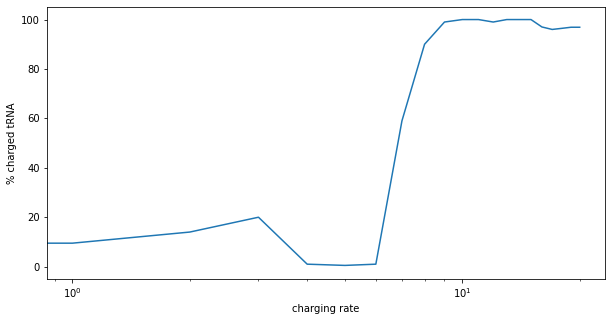

In [31]:
df_fil = df_master[(df_master.species == "TTT_charged")]
rcParams['figure.figsize'] = [10, 5]
df_fil = df_master[(df_master.species == "TTT_charged")]
sns.lineplot(x="tRNA_charging_rate", y="protein", estimator=None, data=df_fil)
plt.xscale("log")
plt.ylabel("% charged tRNA")
plt.xlabel("charging rate")

In [32]:
#!mkdir ../output/june-5-2022/cell_volume_4e-16

In [33]:
cell_volume = "4e-16"
with open(f"../scripts/cmd_files/{date}_{cell_volume}.txt", "w") as stream:
        for trna_charging_rate in trna_charging_rates:
            for seed in range(1, 6):
                cmd = f"python3 twocodonsingletranscript_cellvol.py {config} {seed} {transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"{cell_volume} ../output/{date}/cell_volume_{cell_volume}"
                stream.write(cmd)
                stream.write("\n")

In [36]:
df_master = None

for count, trna_charging_rate in enumerate(trna_charging_rates):
    df_tmp = None
    path = f"../output/{date}/cell_volume_4e-16/two_codon_single_transcript_1.0_0.0_1.0_0.0" + \
           f"_{transcript_copy_number}_{ribosome_copy_number}_{total_trna}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"

    tmp = get_average_protein(path, 1.0, 500, 5)
    if df_tmp is not None:
        df_tmp = df_tmp.append(tmp, ignore_index=True)
    else:
        df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(trna_charging_rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master

,species,protein,codon_comp,tRNA_charging_rate
0,ATA_charged,0.000000,1.0,0.0001
1,ATA_uncharged,0.000000,1.0,0.0001
2,TTT_charged,0.000000,1.0,0.0001
3,TTT_uncharged,100.000000,1.0,0.0001
4,__proteinX_rbs,99.000000,1.0,0.0001
...,...,...,...,...
142,TTT_charged,93.256098,1.0,10.0
143,TTT_uncharged,6.743902,1.0,10.0
144,__proteinX_rbs,99.890244,1.0,10.0
145,__ribosome,99.000000,1.0,10.0


Text(0.5, 0, 'charging rate')

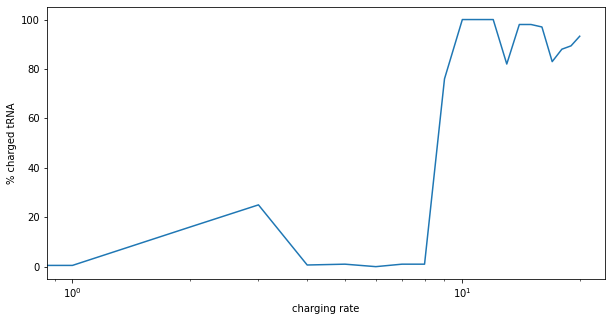

In [37]:
df_fil = df_master[(df_master.species == "TTT_charged")]
rcParams['figure.figsize'] = [10, 5]
df_fil = df_master[(df_master.species == "TTT_charged")]
sns.lineplot(x="tRNA_charging_rate", y="protein", estimator=None, data=df_fil)
plt.xscale("log")
plt.ylabel("% charged tRNA")
plt.xlabel("charging rate")

In [38]:
!mkdir ../output/june-5-2022/cell_volume_8e-15

In [39]:
cell_volume = "8e-15"
with open(f"../scripts/cmd_files/{date}_{cell_volume}.txt", "w") as stream:
        for trna_charging_rate in trna_charging_rates:
            for seed in range(1, 6):
                cmd = f"python3 twocodonsingletranscript_cellvol.py {config} {seed} {transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"{cell_volume} ../output/{date}/cell_volume_{cell_volume}"
                stream.write(cmd)
                stream.write("\n")

In [41]:
df_master = None

for count, trna_charging_rate in enumerate(trna_charging_rates):
    df_tmp = None
    path = f"../output/{date}/cell_volume_8e-15/two_codon_single_transcript_1.0_0.0_1.0_0.0" + \
           f"_{transcript_copy_number}_{ribosome_copy_number}_{total_trna}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"

    tmp = get_average_protein(path, 1.0, 500, 5)
    if df_tmp is not None:
        df_tmp = df_tmp.append(tmp, ignore_index=True)
    else:
        df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(trna_charging_rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master

,species,protein,codon_comp,tRNA_charging_rate
0,ATA_charged,0.0,1.0,0.0001
1,ATA_uncharged,0.0,1.0,0.0001
2,TTT_charged,3.0,1.0,0.0001
3,TTT_uncharged,97.0,1.0,0.0001
4,__proteinX_rbs,100.0,1.0,0.0001
...,...,...,...,...
140,ATA_uncharged,0.0,1.0,10.0
141,TTT_charged,99.5,1.0,10.0
142,TTT_uncharged,0.5,1.0,10.0
143,__proteinX_rbs,99.0,1.0,10.0


Text(0.5, 0, 'charging rate')

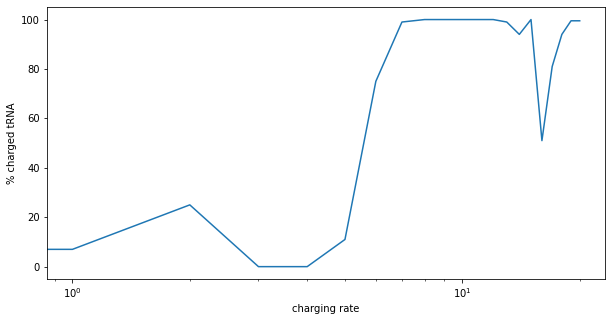

In [42]:
df_fil = df_master[(df_master.species == "TTT_charged")]
rcParams['figure.figsize'] = [10, 5]
df_fil = df_master[(df_master.species == "TTT_charged")]
sns.lineplot(x="tRNA_charging_rate", y="protein", estimator=None, data=df_fil)
plt.xscale("log")
plt.ylabel("% charged tRNA")
plt.xlabel("charging rate")

In [62]:
trna_charging_rates = [1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0, 25000.0, 50000.0, 75000.0, 100000.0]
ribosome_binding_rate = 10000.0

In [60]:
cell_volume = "8e-16"
with open(f"../scripts/cmd_files/{date}_{cell_volume}.txt", "w") as stream:
        for trna_charging_rate in trna_charging_rates:
            for seed in range(1, 6):
                cmd = f"python3 twocodonsingletranscript_cellvol.py {config} {seed} {transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"{cell_volume} ../output/{date}/cell_volume_{cell_volume}"
                stream.write(cmd)
                stream.write("\n")

In [63]:
df_master = None

for count, trna_charging_rate in enumerate(trna_charging_rates):
    df_tmp = None
    path = f"../output/{date}/cell_volume_8e-16/two_codon_single_transcript_1.0_0.0_1.0_0.0" + \
           f"_{transcript_copy_number}_{ribosome_copy_number}_{total_trna}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"

    tmp = get_average_protein(path, 1.0, 500, 5)
    if df_tmp is not None:
        df_tmp = df_tmp.append(tmp, ignore_index=True)
    else:
        df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(trna_charging_rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master

,species,protein,codon_comp,tRNA_charging_rate
0,ATA_charged,0.0,1.0,1.0
1,ATA_uncharged,0.0,1.0,1.0
2,TTT_charged,1.0,1.0,1.0
3,TTT_uncharged,99.0,1.0,1.0
4,__proteinX_rbs,97.0,1.0,1.0
...,...,...,...,...
142,TTT_charged,99.0,1.0,100000.0
143,TTT_uncharged,1.0,1.0,100000.0
144,__proteinX_rbs,98.5,1.0,100000.0
145,__ribosome,82.0,1.0,100000.0


Text(0.5, 0, 'charging rate')

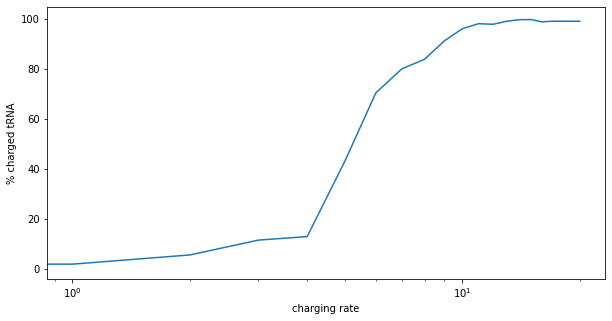

In [64]:
df_fil = df_master[(df_master.species == "TTT_charged")]
rcParams['figure.figsize'] = [10, 5]
df_fil = df_master[(df_master.species == "TTT_charged")]
sns.lineplot(x="tRNA_charging_rate", y="protein", estimator=None, data=df_fil)
plt.xscale("log")
plt.ylabel("% charged tRNA")
plt.xlabel("charging rate")